In [1]:
import numpy as np
from scipy.stats import norm
import random
import pandas as pd
from tqdm import tqdm  

# Define the number of politicians and the dimensionality of the ideal points
dim_ideal_points = 1
num_politicians = 1000
num_bills = 1000
doc_length = 300
vocab_size = 500
num_survey_questions = 100

# Define the parameters of the normal distribution for ideal points
mean_ideal_points = np.zeros(dim_ideal_points)
cov_ideal_points = np.eye(dim_ideal_points)

# Generate ideal points for politicians
ideal_points = np.random.multivariate_normal(mean_ideal_points, cov_ideal_points, num_politicians)

# Function to generate speeches based on ideal points
def generate_speeches(ideal_points, doc_length, vocab_size, progress_bar=False):
    ideal_point_word_matrix = np.random.rand(ideal_points.shape[1], vocab_size)
    
    if progress_bar:
        iterator = tqdm(range(ideal_points.shape[0]))
    else:
        iterator = range(ideal_points.shape[0])
    documents = []
    for i in iterator:
        doc_ideal_points = ideal_points[i]
        doc_words = []
        word_probs = np.dot(doc_ideal_points, ideal_point_word_matrix)
        word_probs = np.exp(word_probs) / np.sum(np.exp(word_probs))
        for _ in range(doc_length):
            word_index = np.random.choice(vocab_size, p=word_probs)
            doc_words.append('word_' + str(word_index))
        doc_words = ' '.join(doc_words)
        documents.append(doc_words)
    return documents

# Function to generate voting behavior based on ideal points
def generate_voting(ideal_points, num_bills, progress_bar=False):
    votes = []
    if progress_bar:
        iterator = tqdm(range(num_bills))
    else:
        iterator = range(num_bills)
    for bill in iterator:
        bill_position = np.random.randn(dim_ideal_points)  # Position of the bill in the ideal point space
        vote_probs = norm.cdf(np.dot(ideal_points, bill_position))  # Probability of voting 'yes'
        votes.append(np.random.binomial(1, vote_probs))
    return np.array(votes).T

# Function to generate survey answers based on ideal points
def generate_survey_answers(ideal_points, num_survey_questions, progress_bar=False):
    survey_answers = []
    if progress_bar:
        iterator = tqdm(range(num_survey_questions))
    else:
        iterator = range(num_survey_questions)
    for survey in iterator:
        categories_per_survey = np.random.randint(2, 6)  # Random number of categories between 2 and 5
        survey_position = np.random.randn(dim_ideal_points, categories_per_survey)  # Position of each category in the ideal point space
        # Calculate the scores for each category
        scores = np.dot(ideal_points, survey_position)
        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))  # Stability fix for softmax
        answer_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # Select the category with the highest probability
        answers = [np.random.choice(categories_per_survey, p=answer_probs[i]) for i in range(ideal_points.shape[0])]
        survey_answers.append(answers)
    return np.array(survey_answers).T

# Generate speeches, voting behavior, and survey answers based on ideal points
speeches = generate_speeches(
    ideal_points,
    doc_length=doc_length,
    vocab_size=vocab_size,
    progress_bar=True
)
voting = generate_voting(
    ideal_points,
    num_bills=num_bills,
    progress_bar=True
)
survey_answers = generate_survey_answers(
    ideal_points,
    num_survey_questions=num_survey_questions,
    progress_bar=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.28it/s]


In [2]:
import numpy as np
import pandas as pd

# Assuming the following variables are already defined:
# speeches, num_politicians, num_bills, voting, survey_answers, num_survey_questions

# Create initial DataFrame
data = pd.DataFrame({'doc_clean': speeches, 'i': range(1, num_politicians + 1)})
vote_cols = [f'vote_{i+1}' for i in range(num_bills)]
vote_data = pd.DataFrame(voting, columns=vote_cols)
survey_cols = [f'Q_{i+1}' for i in range(num_survey_questions)]
survey_data = pd.DataFrame(survey_answers, columns=survey_cols)
data = pd.concat([data, vote_data, survey_data], axis=1)

data['cov0'] = np.random.rand(num_politicians)
data['cov1'] = np.random.rand(num_politicians)
data['t'] = 1

# Ensure vote columns are of type float
data[vote_cols] = data[vote_cols].astype(float)

# Replace X% of the vote column cells with NaN
num_cells = data[vote_cols].size
num_nan = int(num_cells * 0.3)

# Get the flattened array of vote data
flat_vote_data = data[vote_cols].values.flatten()

# Randomly choose indices to replace with NaN
nan_indices = np.random.choice(num_cells, num_nan, replace=False)

# Replace the selected indices with NaN
flat_vote_data[nan_indices] = np.nan

# Reshape the flat array back to the original DataFrame
data[vote_cols] = flat_vote_data.reshape(data[vote_cols].shape)

#data = data.fillna(0)

# Print the DataFrame
print(data.head())

                                           doc_clean  i  vote_1  vote_2  \
0  word_338 word_403 word_319 word_218 word_412 w...  1     0.0     0.0   
1  word_160 word_220 word_459 word_286 word_45 wo...  2     NaN     NaN   
2  word_361 word_204 word_303 word_460 word_388 w...  3     1.0     0.0   
3  word_20 word_231 word_212 word_72 word_132 wor...  4     1.0     1.0   
4  word_378 word_165 word_176 word_251 word_220 w...  5     0.0     1.0   

   vote_3  vote_4  vote_5  vote_6  vote_7  vote_8  ...  Q_94  Q_95  Q_96  \
0     0.0     1.0     0.0     0.0     0.0     1.0  ...     0     2     0   
1     NaN     NaN     1.0     NaN     1.0     1.0  ...     4     0     3   
2     0.0     NaN     0.0     NaN     1.0     0.0  ...     0     3     1   
3     1.0     0.0     0.0     NaN     1.0     0.0  ...     1     1     1   
4     1.0     1.0     NaN     1.0     1.0     0.0  ...     0     0     0   

   Q_97  Q_98  Q_99  Q_100      cov0      cov1  t  
0     3     2     3      0  0.161128  0.

In [3]:
# Create a DataFrame with speeches and voting behavior
#data = pd.DataFrame({'doc_clean': speeches, 'i': range(1, num_politicians + 1)})
#vote_cols = [f'vote_{i+1}' for i in range(num_bills)]
#vote_data = pd.DataFrame(voting, columns=vote_cols)
#survey_cols = [f'Q_{i+1}' for i in range(num_survey_questions)]
#survey_data = pd.DataFrame(survey_answers, columns=survey_cols)
#data = pd.concat([data, vote_data, survey_data], axis=1)

#data['cov0'] = np.random.rand(num_politicians)
#data['cov1'] = np.random.rand(num_politicians)
#data['t'] = 1

# Print the DataFrame
#print(data.head())

In [4]:
import sys
sys.path.append('../IdealPointNN/')
from dataset import IdealPointNNDataset
from ideal_point_model import IdealPointNN

train_data = IdealPointNNDataset(
    data,
    ideology = "~ cov0 + cov1"
)
train_data.add_modality(
    modality = 'text',
    df = data,
)

train_datasets = [train_data]

print(train_data.modalities)

m = IdealPointNN(
    train_datasets, 
    n_dims=dim_ideal_points,
    update_prior=False,
    log_every_n_epochs = 1,
    dropout = 0,
    w_prior = 10,
    batch_size = 32,
    learning_rate=1e-3,
    patience=1, 
    seed = 42,
    num_epochs=30
)

/home/germain/Documents/neural_ideal_points/neural_ideal_point_models/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['text']
Epoch   1	Mean Loss: 1865.2516747

Epoch   2	Mean Loss: 1856.3316765

Epoch   3	Mean Loss: 1855.7613602

Epoch   4	Mean Loss: 1855.6997070

Epoch   5	Mean Loss: 1855.7059822


Early stopping at Epoch 5. Reverting to Epoch 4


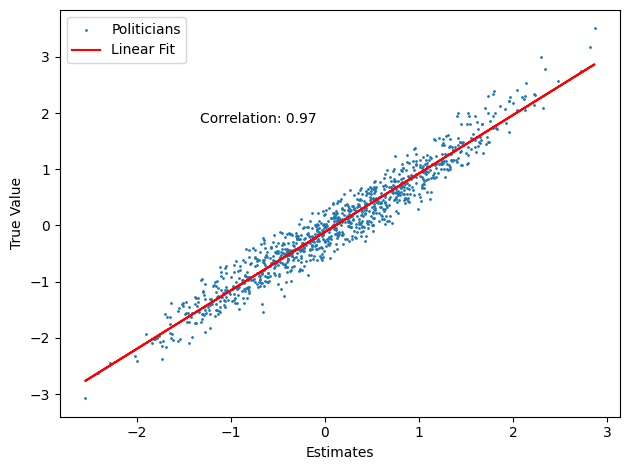

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming m.get_ideal_points and ideal_points are defined
doc_dims = m.get_ideal_points(train_datasets)

x = doc_dims
y = -ideal_points

# Scatter plot of the data
plt.scatter(x, y, label='Politicians', s=1)

# Linear fit
coefficients = np.polyfit(x.flatten(), y.flatten(), 1)
fit = np.poly1d(coefficients)
plt.plot(x, fit(x), color='red', label='Linear Fit')

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(x.flatten(), y.flatten())[0, 1]

# Plot labels and title
plt.xlabel('Estimates')
plt.ylabel('True Value')
#plt.title('True vs. Estimated Ideal Points')
plt.legend()

# Display correlation coefficient on plot
plt.text(0.25, 0.75, f'Correlation: {correlation_coefficient:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.savefig('basic_simulation.pdf')
plt.show()


In [6]:
print(np.corrcoef(x[:,0],y[:,0]))

[[1.         0.96953145]
 [0.96953145 1.        ]]


In [7]:
import sys
sys.path.append('../IdealPointNN/')
from dataset import IdealPointNNDataset
from ideal_point_model import IdealPointNN

train_data = IdealPointNNDataset(
    data,
    ideology = "~ cov0 + cov1"
)
train_data.add_modality(
    modality = 'text',
    df = data,
)
train_data.add_modality(
    modality = 'vote',
    df = data,
    columns = ['vote_{}'.format(i+1) for i in range(num_bills)]
)

train_datasets = [train_data]

print(train_data.modalities)

m = IdealPointNN(
    train_datasets, 
    n_dims=dim_ideal_points,
    update_prior=False,
    log_every_n_epochs = 1,
    dropout = 0,
    w_prior = 1,
    batch_size = 32,
    learning_rate=1e-3,
    patience= 3, 
    seed = 10,
    num_epochs=30
)

['text', 'vote']
Epoch   1	Mean Loss: 1865.4010811

Epoch   2	Mean Loss: 1855.3477898

Epoch   3	Mean Loss: 1854.0745277

Epoch   4	Mean Loss: 1854.0240555

Epoch   5	Mean Loss: 1853.6173172

Epoch   6	Mean Loss: 1853.6534805

Epoch   7	Mean Loss: 1853.4386749

Epoch   8	Mean Loss: 1853.6418877

Epoch   9	Mean Loss: 1853.4998779

Epoch  10	Mean Loss: 1853.0249519

Epoch  11	Mean Loss: 1853.4142303

Epoch  12	Mean Loss: 1853.0951042

Epoch  13	Mean Loss: 1853.1097450


Early stopping at Epoch 13. Reverting to Epoch 10


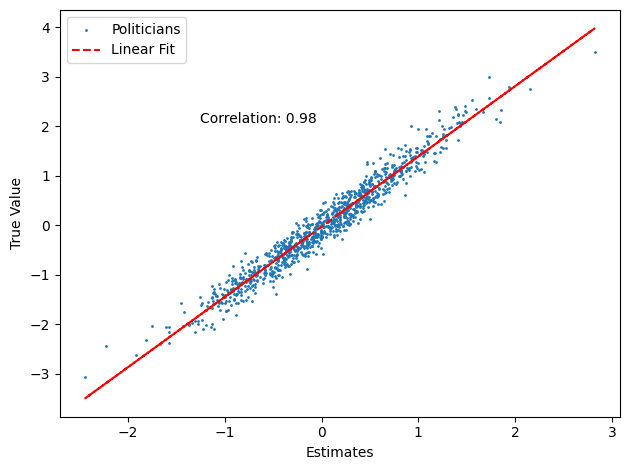

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x1 = -m.get_ideal_points(train_datasets)

# Scatter plot for the first set
plt.scatter(x1, y, label='Politicians', s=1)

# Linear fit for the first set
coefficients_1 = np.polyfit(x1.flatten(), y.flatten(), 1)
fit_1 = np.poly1d(coefficients_1)
plt.plot(x1, fit_1(x1), color='red', linestyle='--', label='Linear Fit')

# Calculate correlation coefficient for the linear fit
correlation_coefficient_1 = np.corrcoef(x1.flatten(), y.flatten())[0, 1]

# Plot labels and title
plt.xlabel('Estimates')
plt.ylabel('True Value')
#plt.title('True vs. Estimated Ideal Points')
plt.legend()

# Display correlation coefficient on plot
plt.text(0.25, 0.75, f'Correlation: {correlation_coefficient_1:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.savefig('multimodal_simulation.pdf')
plt.show()

In [9]:
print(np.corrcoef(x1[:,0],y[:,0]))

[[1.         0.97609373]
 [0.97609373 1.        ]]
